#Dados do aluno




* Nome: Vitor Moreira Ramos de Rezende
* Matrícula: 2022036012
* Link do vídeo: https://www.youtube.com/watch?v=ipfWSbJxCp0



#Projeto

## Descrição Inicial

Este projeto tem como objetivo o treinamento de um modelo BERT consolidado para tarefas de Processamento de Linguagem Natural (PLN) em português: o modelo [Bertimbau](https://dl.acm.org/doi/10.1007/978-3-030-61377-8_28).
Foram utilizados dois datasets voltados para a tarefa de análise de sentimento de comentários em português brasileiro.

Para o treinamento do modelo, foi selecionado, dentre os datasets disponíveis no
[link](https://www.kaggle.com/datasets/fredericods/ptbr-sentiment-analysis-datasets?resource=download) do Kaggle
, o conjunto de dados do Buscapé, uma plataforma online brasileira que atua como assistente de compras, comparando preços e auxiliando consumidores a encontrar as melhores ofertas. Esse dataset contém avaliações de produtos variando de 1 a 5, valores que foram utilizados para classificar os sentimentos dos comentários.

Para os testes, foi utilizado um dataset obtido a partir do
[artigo](https://sol.sbc.org.br/index.php/webmedia/article/view/30297), formado por comentários do Reddit rotulados por humanos, com o objetivo de avaliar o desempenho do modelo treinado.


## Etapa 1 - INICIALIZAÇÃO DO TOKENIZADOR


Inicialização do tokenizador e demais componentes da biblioteca **Transformers** utilizados no projeto.

In [1]:
from transformers import AutoTokenizer
from transformers import AutoModelForPreTraining
from transformers import AutoModel
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

## Etapa 2 - CRIAÇÃO DOS DATAFRAMES DE TREINAMENTO E TESTE

Foram criados os dataframes de treinamento, validação e teste.
O dataset do Buscapé foi reduzido devido às limitações de uso do Google Colab.

Os rótulos foram definidos conforme o critério:

- 1 ou 2 → Negativo

- 3 → Neutro

- 4 ou 5 → Positivo

O dataset de teste possui três colunas de rotulação, seguindo as regras:

- Se duas ou mais colunas possuírem o mesmo rótulo → esse é o rótulo final.

- Se todas forem diferentes → rótulo “Não sei dizer”.

- Todos os comentários rotulados como “Não sei dizer” foram removidos.

Também foi realizado pré-processamento dos textos, removendo URLs, menções e caracteres HTML.


In [2]:
import kagglehub
import pandas as pd
# Download latest version
path = kagglehub.dataset_download("fredericods/ptbr-sentiment-analysis-datasets")

Using Colab cache for faster access to the 'ptbr-sentiment-analysis-datasets' dataset.


In [3]:
import os
print(path)
print(os.listdir(path))

/kaggle/input/ptbr-sentiment-analysis-datasets
['utlc_apps.csv', 'b2w.csv', 'utlc_movies.csv', 'concatenated.csv', 'olist.csv', 'buscape.csv']


In [4]:
df_train = pd.read_csv(os.path.join(path, "buscape.csv"))
print(len(df_train))
df_train.head()

84991


,original_index,review_text,review_text_processed,review_text_tokenized,polarity,rating,kfold_polarity,kfold_rating
0,4_55516,"Estou muito satisfeito, o visor é melhor do qu...","estou muito satisfeito, o visor e melhor do qu...","['estou', 'muito', 'satisfeito', 'visor', 'mel...",1.0,4,1,1
1,minus_1_105339,"""muito boa\n\nO que gostei: preco\n\nO que não...","""muito boa\n\no que gostei: preco\n\no que nao...","['muito', 'boa', 'que', 'gostei', 'preco', 'qu...",1.0,5,1,1
2,23_382139,"Rápida, ótima qualidade de impressão e fácil d...","rapida, otima qualidade de impressao e facil d...","['rapida', 'otima', 'qualidade', 'de', 'impres...",1.0,5,1,1
3,2_446456,Produto de ótima qualidade em todos os quesito!,produto de otima qualidade em todos os quesito!,"['produto', 'de', 'otima', 'qualidade', 'em', ...",1.0,5,1,1
4,0_11324,Precisava comprar uma tv compatível com meu dv...,precisava comprar uma tv compativel com meu dv...,"['precisava', 'comprar', 'uma', 'tv', 'compati...",1.0,5,1,1


In [5]:
def classificar_rating(rating):
    if rating == 3:
        return "Neutro"
    elif rating > 3:
        return "Positivo"
    else:
        return "Negativo"
df_train["resultado"] = df_train["rating"].apply(classificar_rating)

In [6]:
df_train['review_text'] = df_train['review_text'].apply(lambda x: str(x))

In [8]:
df_teste = pd.read_csv("teste.csv")

print(len(df_teste))
df_teste.head()

2000


,Unnamed: 0,id,Comentário,class1,class2,class3
0,0,hr39bh3,"Olha, vou falar sobre a minha experiência. Fui...",Negativo,Negativo,Negativo
1,1,hr4zdgd,Intervencionismo externo visando ganho próprio...,Negativo,Negativo,Negativo
2,2,hr673em,AWS é vida!! Hehehe\nUso e recomendo o todos o...,Positivo,Positivo,Positivo
3,3,hrd2klr,"Se fosse assim, quem morrer de parada cardíaca...",Negativo,Negativo,Neutro
4,4,hrflhlt,"Em momentos como o atual, tomar medidas de pre...",Positivo,Negativo,Negativo


In [9]:
import re
import html
def pre_processamento (x):

  retorno = re.sub(r'(http(s)?://\S+|www\.\S+)|(@\w+)', '', x)
  verdadeiro = re.search(r'&\S+', retorno)

  if verdadeiro:
        retorno = html.unescape(retorno)

  return retorno


In [10]:
df_train['review_text'] = df_train['review_text'].apply(lambda x: pre_processamento(x))
df_teste['Comentário'] = df_teste['Comentário'].apply(lambda x: pre_processamento(x))

In [11]:
def get_class_result(class1, class2, class3):
  if class1 == class2 or class1 == class3 or class2 == class3:
    return class1 if class1 == class2 or class1 == class3 else class3
  else:
    return 'Não sei dizer'

In [12]:
df_teste["resultado"] = df_teste.apply(
    lambda linha: get_class_result(linha["class1"], linha["class2"], linha["class3"]),
    axis=1
)
df_teste = df_teste[df_teste['resultado'] != 'Não sei dizer']


In [13]:
def processar_rotulos(rotulo):
  if rotulo == 'Positivo':
    return 2
  elif rotulo == 'Neutro':
    return 1
  elif rotulo == 'Negativo':
    return 0

In [14]:
df_teste['resultado'] = df_teste['resultado'].apply(lambda x: processar_rotulos(x))
df_train['resultado'] = df_train['resultado'].apply(lambda x: processar_rotulos(x))

In [15]:
df_teste.head(5)

,Unnamed: 0,id,Comentário,class1,class2,class3,resultado
0,0,hr39bh3,"Olha, vou falar sobre a minha experiência. Fui...",Negativo,Negativo,Negativo,0
1,1,hr4zdgd,Intervencionismo externo visando ganho próprio...,Negativo,Negativo,Negativo,0
2,2,hr673em,AWS é vida!! Hehehe\nUso e recomendo o todos o...,Positivo,Positivo,Positivo,2
3,3,hrd2klr,"Se fosse assim, quem morrer de parada cardíaca...",Negativo,Negativo,Neutro,0
4,4,hrflhlt,"Em momentos como o atual, tomar medidas de pre...",Positivo,Negativo,Negativo,0


In [16]:
df_neg = df_train[df_train['resultado'] == 0].head(1500).copy()
df_neu = df_train[df_train['resultado'] == 1].head(1500).copy()
df_pos = df_train[df_train['resultado'] == 2].head(1500).copy()
df_train_adjust = pd.concat([df_neg, df_neu, df_pos], ignore_index=True)

## Etapa 3


Foi criada a classe BertDataset, uma implementação personalizada de Dataset do PyTorch, responsável por preparar os textos e rótulos para serem consumidos pelo BERTimbau durante o treinamento.
Ela realiza tokenização, truncamento, criação de máscaras de atenção e organização dos tensores.

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [18]:
MAX_LENGTH = 64
RANDOM_SEED = 42

In [19]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [20]:
class BertDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, index):
    review = str(self.reviews[index])
    target = self.targets[index]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      #padding='longest',
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

##Etapa 4 - TREINAMENTO


Realizou-se o treinamento e avaliação do modelo BERTimbau utilizando Validação Cruzada K-Fold (10 folds).
Para cada fold, uma nova instância do modelo foi criada, e o dataset completo foi dividido em subconjuntos de treinamento e validação.

O treinamento ocorreu em até 50 épocas, calculando acurácia, precisão, recall e F1-score a cada época.

Utilizou-se Early Stopping, com patience=1, salvando o estado do modelo que obteve a melhor perda de validação.

Ao final, foram registradas as métricas médias dos 10 folds.

In [21]:
from transformers import AutoModelForSequenceClassification

In [22]:
import transformers

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [24]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

In [25]:
k_folds = 10
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

In [26]:
from sklearn.metrics import precision_recall_fscore_support

In [27]:
def train_model(model, data_loader, criterian, optimizer, scheduler):

    model.train()
    train_loss = []
    correct_pred = 0
    all_predictions = []
    all_targets = []

    for d in data_loader:

        input_ids = d['input_ids'].to(device)
        attention_masks = d['attention_mask'].to(device)
        targets = d['targets'].to(device)

        # forward prop
        predictions = model(input_ids , attention_masks)
        loss = criterian(predictions.logits, targets)

        _,pred_classes = torch.max(predictions.logits, dim=1)
        #backprop
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        #scheduler.step()
        optimizer.zero_grad()
        train_loss.append(loss.item())

        correct_pred += torch.sum(pred_classes==targets)
        all_predictions.extend(pred_classes.cpu().numpy()) #extend significa que vai colocar vários itens de uma vez
        #o pred_classes está no gpu, mas a função que calcula o f1_score precisa que esteja no cpu
        all_targets.extend(targets.cpu().numpy())

    precision, recall, f1_score, _ = precision_recall_fscore_support(
        all_targets, all_predictions, average='weighted', zero_division=1
    )
    acc = accuracy_score(all_targets, all_predictions)

    return acc, precision, recall, f1_score, np.mean(train_loss)

In [28]:
def eval_model(model, data_loader, criterian):
    model.eval()
    eval_loss = []
    correct_pred = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for d in data_loader:

            input_ids = d['input_ids'].to(device)
            attention_masks = d['attention_mask'].to(device)
            targets = d['targets'].to(device)

            # forward prop
            predictions = model(input_ids , attention_masks)
            loss = criterian(predictions.logits, targets)
            _,pred_classes = torch.max(predictions.logits, dim=1)
            eval_loss.append(loss.item())

            correct_pred += torch.sum(pred_classes==targets)
            all_predictions.extend(pred_classes.cpu().numpy()) #extend significa que vai colocar vários itens de uma vez
            #o pred_classes está no gpu, mas a função que calcula o f1_score precisa que esteja no cpu
            all_targets.extend(targets.cpu().numpy())

    precision, recall, f1_score, _ = precision_recall_fscore_support(
        all_targets, all_predictions, average='weighted', zero_division=1
    )

    acc = accuracy_score(all_targets, all_predictions)

    return acc, precision, recall, f1_score, np.mean(eval_loss)

In [29]:
class EarlyStopper:
    def __init__(self, patience, min_delta):
        self.patience = patience #número épocas que serviram como limite para a perda voltar a diminuir
        self.min_delta = min_delta #número minímo que considera que houve diminuição
        self.counter = 0 #contador
        self.min_validation_loss = float('inf') #menor valor de perda de validação, iniciado com infinito

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [31]:
models = []

In [32]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)


fold_accuracies = []
fold_f1_score = []
fold_recall = []
fold_precision = []


full_dataset = BertDataset(
    reviews=df_train_adjust["review_text"].to_numpy(),
    targets=df_train_adjust["resultado"].to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LENGTH
)

for fold, (train_index, val_index) in enumerate(kf.split(df_train_adjust)): #contador(fold) e indices que definem os comentários de treinamento e validação
    print(f"Training Fold {fold+1}/{k_folds}")

    model = AutoModelForSequenceClassification.from_pretrained('neuralmind/bert-base-portuguese-cased', num_labels=3).to(device)

    train_dataset = torch.utils.data.Subset(full_dataset, train_index)
    val_dataset = torch.utils.data.Subset(full_dataset, val_index)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Training loop
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
    criterion = torch.nn.CrossEntropyLoss().to(device)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    acuracia_val = None
    f1_score_val = None
    precisao_val = None
    recall_val = None
    loss_val = None

    acuracia_val_antigo = None
    precisao_val_antigo = None
    recall_val_antigo = None
    f1_score_val_antigo = None
    loss_val_antigo = None

    model.train()

    verificar_parada = EarlyStopper(1, 0.001)

    melhor_model = [] #salva o melhor modelo do epoch

    for epoch in range(50):
        #treinamento
        train_acc, train_precision, train_recall, train_f1_score, train_loss = train_model(model,
                                         train_loader,
                                         criterion,
                                         optimizer,
                                         None,
                                        )

        #validação
        acuracia_val, precisao_val, recall_val, f1_score_val, loss_val = eval_model(model,
                                    val_loader,
                                    criterion,
                                   )

        if verificar_parada.early_stop(loss_val):
          print()
          print(f"loss antiga: {loss_val_antigo}, loss atual: {loss_val}" )
          torch.save(melhor_model[0], melhor_model[1])
          print(f"MODELO_{fold} Accuracy: {acuracia_val_antigo}, F1_Score: {f1_score_val_antigo}, recall_Val: {recall_val_antigo}, precisao: {precisao_val_antigo} loss: {loss_val_antigo}")
          print()
          break

        melhor_model = []
        melhor_model.append(model.state_dict())
        melhor_model.append(f'/content/drive/MyDrive/modelos_final/model_state_{fold}.bin')
        models.append(model)

        acuracia_val_antigo = acuracia_val
        precisao_val_antigo = precisao_val
        recall_val_antigo = recall_val
        f1_score_val_antigo = f1_score_val

    fold_accuracies.append(acuracia_val_antigo)
    fold_f1_score.append(f1_score_val_antigo)
    fold_recall.append(recall_val_antigo)
    fold_precision.append(precisao_val_antigo)


# Calculate average accuracy across all folds
average_accuracy = sum(fold_accuracies) / len(fold_accuracies)
print(f"MEDIAN => Accuracy: {average_accuracy} F1_score: {sum(fold_f1_score)/len(fold_f1_score)} recall: {sum(fold_recall)/len(fold_recall)} precision: {sum(fold_precision)/len(fold_precision)}")

Training Fold 1/10


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]


loss antiga: None, loss atual: 0.8152521888415019
MODELO_0 Accuracy: 0.6288888888888889, F1_Score: 0.6257115586552464, recall_Val: 0.6288888888888889, precisao: 0.6236771667731419 loss: None

Training Fold 2/10


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



loss antiga: None, loss atual: 0.8963822960853577
MODELO_1 Accuracy: 0.6488888888888888, F1_Score: 0.6480699061179088, recall_Val: 0.6488888888888888, precisao: 0.6494422007233243 loss: None

Training Fold 3/10


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



loss antiga: None, loss atual: 0.835705057779948
MODELO_2 Accuracy: 0.6377777777777778, F1_Score: 0.6304628104352661, recall_Val: 0.6377777777777778, precisao: 0.636354748161314 loss: None

Training Fold 4/10


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



loss antiga: None, loss atual: 0.8259403944015503
MODELO_3 Accuracy: 0.6333333333333333, F1_Score: 0.6141779059934507, recall_Val: 0.6333333333333333, precisao: 0.6386867933951961 loss: None

Training Fold 5/10


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



loss antiga: None, loss atual: 0.8529816071192423
MODELO_4 Accuracy: 0.6311111111111111, F1_Score: 0.6316571090289322, recall_Val: 0.6311111111111111, precisao: 0.6367302912632146 loss: None

Training Fold 6/10


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



loss antiga: None, loss atual: 0.8515035470326742
MODELO_5 Accuracy: 0.6711111111111111, F1_Score: 0.6741030327385532, recall_Val: 0.6711111111111111, precisao: 0.682189054726368 loss: None

Training Fold 7/10


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



loss antiga: None, loss atual: 0.8326222618420919
MODELO_6 Accuracy: 0.6622222222222223, F1_Score: 0.6617080612037701, recall_Val: 0.6622222222222223, precisao: 0.6622345927845495 loss: None

Training Fold 8/10


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



loss antiga: None, loss atual: 0.7438569148381551
MODELO_7 Accuracy: 0.6733333333333333, F1_Score: 0.674325383411391, recall_Val: 0.6733333333333333, precisao: 0.6788654526693969 loss: None

Training Fold 9/10


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



loss antiga: None, loss atual: 0.7572685857613881
MODELO_8 Accuracy: 0.6577777777777778, F1_Score: 0.6448880919255098, recall_Val: 0.6577777777777778, precisao: 0.6630091673983243 loss: None

Training Fold 10/10


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



loss antiga: None, loss atual: 0.8526945809523264
MODELO_9 Accuracy: 0.66, F1_Score: 0.6493625541901403, recall_Val: 0.66, precisao: 0.6641562463078822 loss: None

MEDIAN => Accuracy: 0.6504444444444444 F1_score: 0.6454466413700168 recall: 0.6504444444444444 precision: 0.6535345714202712


##Etapa 5 - TESTES DOS MODELOS

Após o treinamento, os 10 modelos resultantes foram avaliados usando o dataset de teste.
As métricas calculadas foram:

- Acurácia

- F1-score

- Precisão

- Recall

O modelo com melhor acurácia foi selecionado para análise detalhada.

In [33]:
num_classes = 3
model_name = 'neuralmind/bert-base-portuguese-cased'

In [34]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:

            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"]

            outputs = model(input_ids=input_ids,
                            attention_mask=attention_mask)

            _, preds = torch.max(outputs.logits, dim=1)

            probs = F.softmax(outputs.logits, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

In [35]:
BATCH_SIZE = 32
df_teste_dataset = BertDataset(
    reviews=df_teste["Comentário"].to_numpy(),
    targets=df_teste["resultado"].to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LENGTH
)
test_loader = DataLoader(df_teste_dataset, batch_size=BATCH_SIZE, shuffle=True) #shuffle=True evirar overfitting


In [36]:
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    classification_report
)
from sklearn.metrics import accuracy_score

In [37]:
from tqdm import tqdm
import torch.nn.functional as F

fold_accuracies = []
fold_f1_score = []
fold_recall = []
fold_precision = []

for i in range(10):
  #best_model_path = f'/content/drive/MyDrive/8periodo/nlp/modelos_final/model_state_{i}.bin'
  model = models[i]#AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_classes).to(device)
  ##model.load_state_dict(torch.load(best_model_path))
  y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model,test_loader)
  acc_t = accuracy_score(y_test, y_pred)
  f1_score_t = f1_score(y_test, y_pred, average='weighted')
  precisao_t = precision_score(y_test, y_pred, average='weighted')
  recall_t = recall_score(y_test, y_pred, average='weighted')
  print()
  print(f"modelo_{i}  acc: {acc_t}, f1_score: {f1_score_t}, precisao: {precisao_t}, recall: {recall_t}")
  print()
  fold_accuracies.append(acc_t)
  fold_f1_score.append(f1_score_t)
  fold_precision.append(precisao_t)
  fold_recall.append(recall_t)
print(f"MEDIAN => Accuracy: {sum(fold_accuracies)/len(fold_accuracies)} F1_score: {sum(fold_f1_score)/len(fold_f1_score)} recall: {sum(fold_recall)/len(fold_recall)} precision: {sum(fold_precision)/len(fold_precision)}")


modelo_0  acc: 0.6125439624853458, f1_score: 0.5450951529518735, precisao: 0.5796823563869685, recall: 0.6125439624853458


modelo_1  acc: 0.5920281359906213, f1_score: 0.5665996029511551, precisao: 0.5642421614234046, recall: 0.5920281359906213


modelo_2  acc: 0.5920281359906213, f1_score: 0.5665996029511551, precisao: 0.5642421614234046, recall: 0.5920281359906213


modelo_3  acc: 0.5920281359906213, f1_score: 0.5665996029511551, precisao: 0.5642421614234046, recall: 0.5920281359906213


modelo_4  acc: 0.5920281359906213, f1_score: 0.5665996029511551, precisao: 0.5642421614234046, recall: 0.5920281359906213


modelo_5  acc: 0.6172332942555686, f1_score: 0.5571375966721077, precisao: 0.5659064120783566, recall: 0.6172332942555686


modelo_6  acc: 0.5691676436107854, f1_score: 0.5413702347563754, precisao: 0.5453468667972358, recall: 0.5691676436107854


modelo_7  acc: 0.5691676436107854, f1_score: 0.5413702347563754, precisao: 0.5453468667972358, recall: 0.5691676436107854


modelo_

**MEDIAN => Accuracy: 0.5955451348182883 F1_score: 0.558971101527068 recall: 0.5955451348182883 precision: 0.5630534356449262**

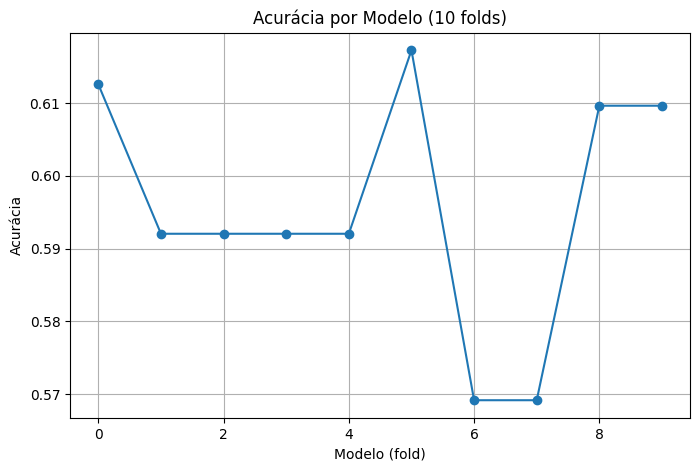

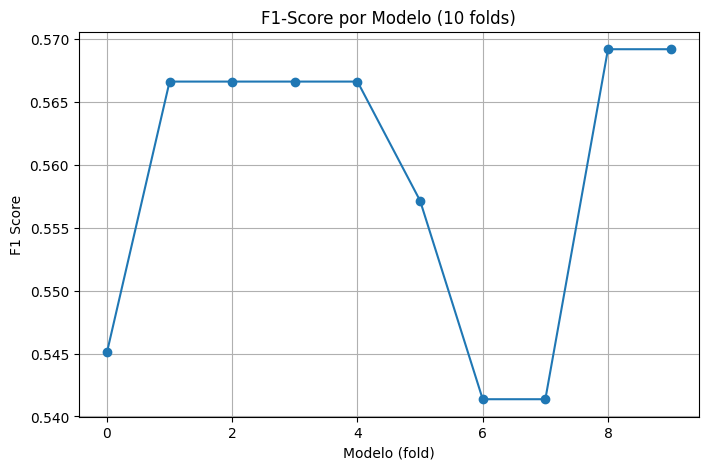

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(range(0, len(fold_accuracies)), fold_accuracies, marker='o')
plt.title("Acurácia por Modelo (10 folds)")
plt.xlabel("Modelo (fold)")
plt.ylabel("Acurácia")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(0, len(fold_f1_score)), fold_f1_score, marker='o')
plt.title("F1-Score por Modelo (10 folds)")
plt.xlabel("Modelo (fold)")
plt.ylabel("F1 Score")
plt.grid(True)
plt.show()

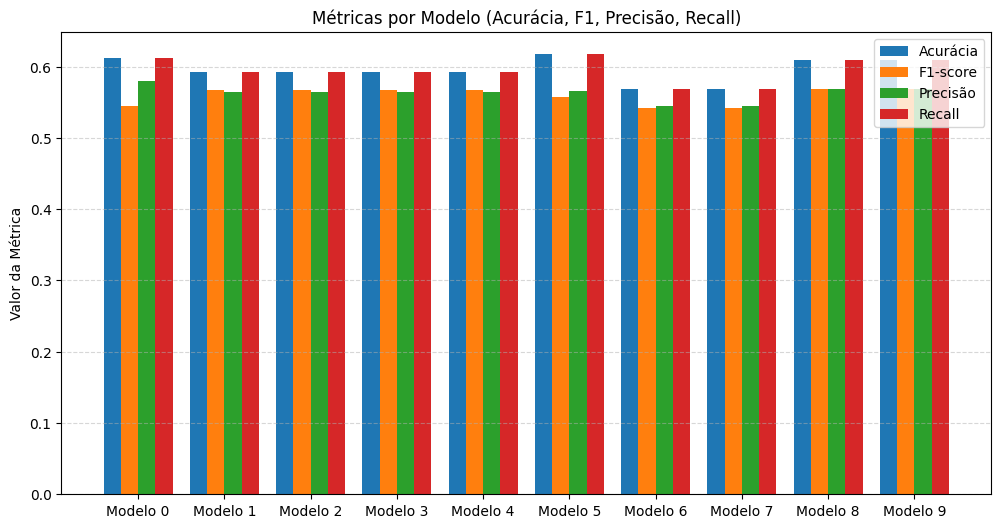

In [39]:
import numpy as np
import matplotlib.pyplot as plt

n = len(fold_accuracies)

indices = np.arange(n)

largura = 0.2

plt.figure(figsize=(12,6))

plt.bar(indices - 1.5*largura, fold_accuracies, width=largura, label="Acurácia")
plt.bar(indices - 0.5*largura, fold_f1_score, width=largura, label="F1-score")
plt.bar(indices + 0.5*largura, fold_precision, width=largura, label="Precisão")
plt.bar(indices + 1.5*largura, fold_recall, width=largura, label="Recall")

plt.xticks(indices, [f"Modelo {i}" for i in range(n)])
plt.ylabel("Valor da Métrica")
plt.title("Métricas por Modelo (Acurácia, F1, Precisão, Recall)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

###**MODELO COM MELHOR ACURÁCIA: MODELO_5**

##Etapa Final - ANALIZE DOS DADOS DO MELHOR MODELO

O modelo de melhor desempenho/acurácia foi avaliado novamente no dataset de teste, e foram gerados gráficos com os resultados de suas métricas:

- Acurácia

- F1-score

- Precisão

- Recall

Essas métricas permitem observar o desempenho do classificador em dados nunca antes vistos, demonstrando a eficácia do modelo treinado.

In [43]:

#best_model_path = f'/content/drive/MyDrive/m_bertimbau/model_state_{7}.bin'
model = models[5] #AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_classes).to(device)
#model.load_state_dict(torch.load(best_model_path))
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model,test_loader)
acc_t = accuracy_score(y_test, y_pred)
f1_score_t = f1_score(y_test, y_pred, average='weighted')
precisao_t = precision_score(y_test, y_pred, average='weighted')
recall_t = recall_score(y_test, y_pred, average='weighted')
print()
print(f"modelo_{5}  acc: {acc_t}, f1_score: {f1_score_t}, precisao: {precisao_t}, recall: {recall_t}")
print()



modelo_5  acc: 0.6172332942555686, f1_score: 0.5571375966721077, precisao: 0.5659064120783566, recall: 0.6172332942555686



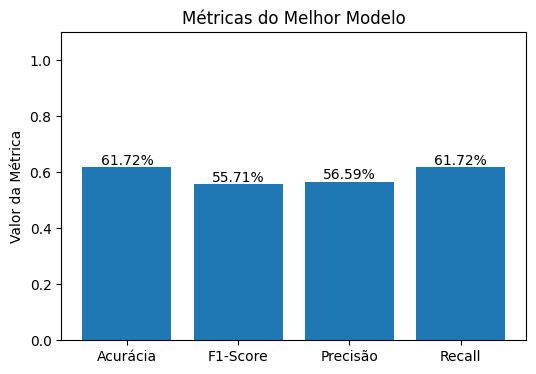

In [44]:
import matplotlib.pyplot as plt

# métricas do seu melhor modelo
metrics = {
    "Acurácia": acc_t,
    "F1-Score": f1_score_t,
    "Precisão": precisao_t,
    "Recall": recall_t
}

names = list(metrics.keys())
values = list(metrics.values())

plt.figure(figsize=(6,4))
bars = plt.bar(names, values)

# adicionar valores acima das barras (em %)
for bar, value in zip(bars, values):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        value + 0.01,
        f"{value*100:.2f}%",  # converte para porcentagem
        ha='center',
        fontsize=10
    )

plt.ylim(0, 1.1)  # escala até 110% para folga no texto
plt.ylabel("Valor da Métrica")
plt.title("Métricas do Melhor Modelo")
plt.show()

In [45]:
import numpy as np
import matplotlib.pyplot as plt

labels = ["Negativo", "Neutro", "Positivo"]

# contadores
correct_by_class = {label: 0 for label in labels}
wrong_by_class   = {label: 0 for label in labels}
total_by_class   = {label: 0 for label in labels}


for true, pred in zip(y_test, y_pred):
    true_label = labels[true]
    total_by_class[true_label] += 1

    if true == pred:
        correct_by_class[true_label] += 1
    else:
        wrong_by_class[true_label] += 1


correct_pct = []
wrong_pct = []
for label in labels:
    total = total_by_class[label]
    correct_pct.append(100 * correct_by_class[label] / total)
    wrong_pct.append(100 * wrong_by_class[label] / total)

Em relação ao teste com o dataset de teste, o rótulo que o modelo mais acertou foi Negativo. Ainda assim, ele apresenta um desempenho satisfatório também para o rótulo Positivo, acertando mais do que errando. Entretanto, para o rótulo Neutro, o desempenho é significativamente inferior, com uma quantidade elevada de erros. Isso ocorre porque comentários neutros costumam ser mais difíceis de identificar, já que muitas vezes possuem pouca carga emocional ou são ambíguos.

Além disso, é importante destacar que utilizar os valores numéricos das avaliações como forma de gerar rótulos pode não ser a abordagem mais adequada. Como pode ser observado nos comentários de exemplo do dataset de treinamento, a presença frequente de frases simples como “gostei” ou “não gostei” pode ter influenciado o modelo de maneira excessiva. Mesmo dentro da classe Negativo, que foi a que o modelo mais acertou, há comentários com pouca coerência como no caso do segundo exemplo de comentário rotulado como negativo o que pode ter contribuído para ruído durante o treinamento.

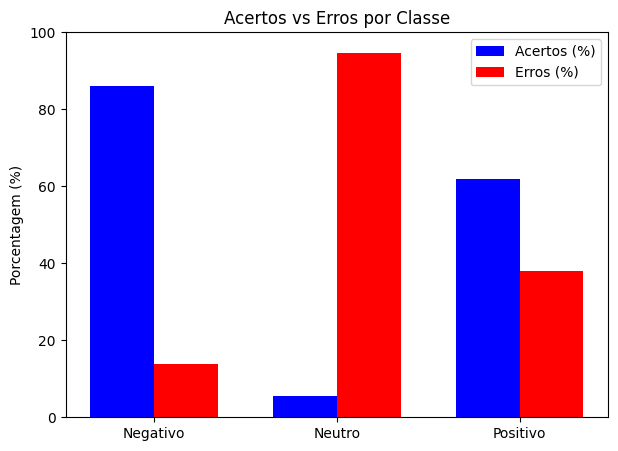

In [62]:
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(7,5))
plt.bar(x - width/2, correct_pct, width, label="Acertos (%)", color="blue")
plt.bar(x + width/2, wrong_pct,   width, label="Erros (%)", color="red")

plt.xticks(x, labels)
plt.ylabel("Porcentagem (%)")
plt.title("Acertos vs Erros por Classe")
plt.ylim(0, 100)
plt.legend()
plt.show()

In [57]:
print('fase 1: ',df_train_adjust[df_train_adjust['resultado'] == 0].head(2)['review_text'].tolist()[0])
print()
print('fase 2: ', df_train_adjust[df_train_adjust['resultado'] == 0].head(2)['review_text'].tolist()[1])

fase 1:  nao comparia novamente essa marca, pois paguei caro e me decepcionei com a durabilidade

O que gostei: se vc for ver e analisar, parece uma ótima tv, porem comprei uma lcd 42 full hd, conversor, e que durou apenas 1 ano e meio, alem da assistencia técnica pessima, o conserto nao fica abaixo dos 700,00, só entrar no site "reclame aqui" e ver como essa marca da problema em televisores..cuidado fiquem alerta

O que não gostei: a durabilidade

fase 2:  tem uma boa aderencia te da mas agilidades no dribles e confortavel

O que gostei: tem uma boa aderencia te da mas agilidades no dribles e confortavel

O que não gostei: tem uma boa aderencia te da mas agilidades no dribles e confortavel


In [59]:
print('fase 1: ',df_train_adjust[df_train_adjust['resultado'] == 1].head(2)['review_text'].tolist()[0])
print()
print('fase 2: ', df_train_adjust[df_train_adjust['resultado'] == 1].head(2)['review_text'].tolist()[1])

fase 1:  bom

O que gostei: muitos aplicativos gratis para baixar

O que não gostei: os melhores sao pagos e em moedas extrangeiras

fase 2:  Na ocasião da compra estava em duvida em relação a fornos mais baratos. Entretanto valeu muito a diferença de preço pois o forno é muito bom, além de ser bonito. Utilizo o meu diariamente e estou extremamente satisfeito na medida em que substituiu totalmente o meu forno a gás.

O que gostei: Várias funções que permitem a você controlar bem como aquecerá o interior do forno, mas ao mesmo tempo simples de utilizar. A estética é muito bonita e ficou muito bem na minha cozinha. A porta que abre para o lado também facilita muito para um forno embutido.

O que não gostei: Nenhum até o momento.


In [63]:
print('fase 1: ',df_train_adjust[df_train_adjust['resultado'] == 2].head(2)['review_text'].tolist()[0])
print()
print('fase 2: ', df_train_adjust[df_train_adjust['resultado'] == 2].head(3)['review_text'].tolist()[1])

fase 1:  Estou muito satisfeito, o visor é melhor do que eu imaginava, boas imagens, desing ultra fino. Pelo preço é um exelente aparelho.

O que gostei: Desing exelente, display, custo beneficio.

O que não gostei: Não tem como adicionar mais papeis de parede, bateria dura pouco.

fase 2:  "muito boa

O que gostei: preco

O que não gostei: poderia ser 42


resultado
Negativo    1500
Neutro      1500
Positivo    1500
Name: count, dtype: int64


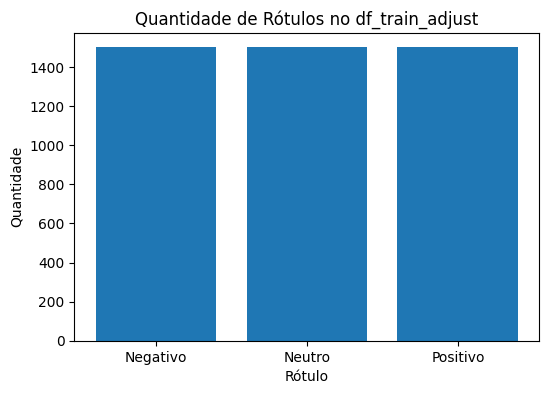

In [61]:
import matplotlib.pyplot as plt

mapping = {0: "Negativo", 1: "Neutro", 2: "Positivo"}

label_counts = df_train_adjust["resultado"].map(mapping).value_counts().reindex(
    ["Negativo", "Neutro", "Positivo"], fill_value=0
)

print(label_counts)

plt.figure(figsize=(6,4))
plt.bar(label_counts.index, label_counts.values)
plt.xlabel("Rótulo")
plt.ylabel("Quantidade")
plt.title("Quantidade de Rótulos no df_train_adjust")
plt.show()